<a href="https://colab.research.google.com/github/ipavlopoulos/paremia/blob/main/spatial_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spatial Analysis: Text Classification, Clustering, and Regression

* Using a collection of proverbs from the [Hellenic Folklore Research Centre](http://www.kentrolaografias.gr/) of the Academy of Athens.
* Using [Folium](https://pypi.org/project/folium/), [Geopy](https://geopy.readthedocs.io/en/stable/), and [scikit-learn](https://scikit-learn.org/stable/) algorithms for hierarchical clustering, classification and regression.

---


In [1]:
%%capture
!pip install geopandas
!pip install geopy
!pip install folium
!pip install gdown
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import folium
from tqdm.notebook import tqdm
from folium import Choropleth, Circle, CircleMarker, Marker
from folium.plugins import MarkerCluster
from collections import Counter
import nltk; nltk.download('stopwords')
import matplotlib.pyplot as plt

## Loading the data

In [2]:
proverbs = pd.read_csv("https://raw.githubusercontent.com/ipavlopoulos/paremia/main/input/proverbs.csv", index_col=0)
proverbs.shape

(134493, 4)

In [3]:
proverbs.sample(3)

,text,place,uri,collector
31077,"Θα 'χης δώδεκα μυαλά, για να σου αφίση το 'να",Επτάνησος,http://hdl.handle.net/20.500.11853/284534,"Καββαδίας, Γεώργιος"
91304,Ου λόγους είν' σπόρους,"Ιωάννινα, Νεγάδες",http://hdl.handle.net/20.500.11853/211628,"Οικονόμου, Μάνθος Κ."
107269,Μάϊος Μάϊγ'ς μάγιους Μα,"Λέσβος, Πλαγιά",http://hdl.handle.net/20.500.11853/262056,"Σαρέλλης, Εμμανουήλ"


* Few proverbs comrpise definitions, removing them

In [4]:
proverbs[proverbs.text.str.contains("=")].sample().text.item()

'Αθρωπομίλητος,η,ο = επί ζώων εχόντων ανθρωπίνων λαλιά κατα το παραμύθια ή εν γένει επί ζώων μοημόνων.'

In [5]:
proverbs = proverbs[~proverbs.text.str.contains("=")]
proverbs.shape

(134106, 4)

* Also, duplicates exist.

In [6]:
proverbs[proverbs.duplicated()]

,text,place,uri,collector
62809,Απού δε θέλει χτύπους στο χαρκιδιό δεν πάει,"Κρήτη, Αποκόρωνας, Μελιδόνι",http://hdl.handle.net/20.500.11853/161130,"Λιουδάκη, Μαρία"
62810,"Απού δε σπείρη τον Οχτώβρη, οχτώ σωρούς δεν κάνει","Κρήτη, Λασίθι, Τζερμιάδο",http://hdl.handle.net/20.500.11853/288692,"Λιουδάκη, Μαρία"
62811,"Απού διαλέει, πάει ποδιαλεμάτου","Κρήτη, Λασίθι, Άγιος Γεώργιος",http://hdl.handle.net/20.500.11853/163118,"Λιουδάκη, Μαρία"
62812,Απού δουλεύγει βασιλιά το νού ντου πρέπει νάχη...,"Κρήτη, Ρέθυμνο",http://hdl.handle.net/20.500.11853/151409,"Λιουδάκη, Μαρία"
62813,Απού ζυμώση και πλυθή σαράντα μέρες είν' καλή,"Κρήτη, Λασίθι, Άγιος Γεώργιος",http://hdl.handle.net/20.500.11853/163084,"Λιουδάκη, Μαρία"
...,...,...,...,...
134488,Απ' ούλα τα φαΓια το ρύζ' και τσόχα να φορής,"Θράκη, Σαμακόβι",http://hdl.handle.net/20.500.11853/245653,anonymous
134489,Απ' τ' Άη – Λιός και μπρός γυρίζει ο καιρός αλ...,"Μεσσηνία, Φιλιατρά",http://hdl.handle.net/20.500.11853/160335,anonymous
134490,Απ' τ' Άι – Ηλιά το βράδυ βάζει η ελιά το λάδι,Σίφνος,http://hdl.handle.net/20.500.11853/190853,anonymous
134491,Απ' τ' άλουγου στου γουμάρι,Ήπειρος,http://hdl.handle.net/20.500.11853/159862,anonymous


* There are more duplicates when considering the `text` column only.

In [7]:
proverbs['text'].duplicated().sum()

24836

* Climbing up to the highest-level information per location labelled.

* In 'Κέρκυρα, Οθωνοί', for example, we only keep the first part of the term, using `split` to tokenise.

In [8]:
proverbs["area"] = proverbs.place.map(lambda x: x.split(",")[0])
proverbs.sample(3)

,text,place,uri,collector,area
104459,Ας με λέν' Βοϊβοντίνα κι ας πεθαίν' από την πείνα,"Ήπειρος, Κόνιτσα",http://hdl.handle.net/20.500.11853/276170,"Ρεμπέλης, Χαράλαμπος",Ήπειρος
105560,Ένας παλαβός ρίχιν' τ' μπέτρα στου πγάδ τσι χί...,"Κρήτη, Κυδωνία",http://hdl.handle.net/20.500.11853/284416,"Σάκκαρης, Γεώργιος",Κρήτη
105282,Η καλή μέρα από το πρωΐ τση φαίνεται,"Κρήτη, Σητεία, Σκοπή",http://hdl.handle.net/20.500.11853/183313,"Ρουσσομουστακάκης, Νικόλαος",Κρήτη


* One more observation regards proverbs with no information about their location 


In [9]:
len(proverbs[proverbs.area=='Άδηλου τόπου'].text.unique())

3698

# Geolocating

* There are 134 unique broad areas registered in the collection

In [10]:
locations = proverbs.area.unique()
len(locations)

134

* We will find the geographical coordinates of each one
* Using [geopy](https://geopy.readthedocs.io/en/stable/#), which is a Python client for geocoding web services, locating the coordinates (e.g., of addresses, cities, countries) across the globe.



In [11]:
from geopy.geocoders import Nominatim # import the library
geolocator = Nominatim(user_agent="paremia") # initialise it

* We want to geocode each location in our dataframe
* Adding the country's name in the query improves the accuracy
* But geolocation still doesn't work for all places, printing them to fix with hardcoding  

In [12]:
geolocs = {}
for loc in locations:
    # Avoiding polysemy by including "Greece" in the query
    location = geolocator.geocode(loc+ ", Ελλάδα") 
    if location:
        geolocs[loc] = {"lat":location.latitude, "lon":location.longitude}
    else:
        print (loc)

Άδηλου τόπου
Φθιώτιδα
Αδριανούπολη
Δυτική Μάνη
Καππαδοκία
Δαρδανέλλια (Ελλήσποντος)
Αλβανία
Φωκίδα
Ημαθία
Βοιωτία
Αερόπολη
Τριφυλία
Μπλάτση
Ανατολική Κρήτη
Ανατολική Θράκη
Ανδρίτσαινα Ολυμπίου
Δυτική Κρήτη
Στερεά Ελλάδα
Ναυπακτία
Δωδεκάνησα
Λεπενού Αιτωλοακαρνανίας (επαρχία Βάλτου)


* Fixing places which were problematic.

* Cyprus was also ambiguous and mislocated.

In [13]:
# fixing some by hand
location = geolocator.geocode("Cyprus")
geolocs["Κύπρος"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Siteia")
geolocs["Ανατολική Κρήτη"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Chania")
geolocs["Δυτική Κρήτη"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Nafpaktia")
geolocs["Ναυπακτία"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Lepenou")
geolocs["Λεπενού Αιτωλοακαρνανίας (επαρχία Βάλτου)"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Cappadocia")
geolocs["Καππαδοκία"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Imathia")
geolocs["Ημαθία"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Boeotia")
geolocs["Βοιωτία"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Edirne")
geolocs["Ανατολική Θράκη"] = {"lat":location.latitude, "lon":location.longitude}
geolocs["Αδριανούπολη"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Phthiotis")
geolocs["Φθιώτιδα"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Andritsaina")
geolocs["Ανδρίτσαινα Ολυμπίου"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Dardanelles Strait")
geolocs["Δαρδανέλλια (Ελλήσποντος)"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Central Greece")
geolocs["Στερεά Ελλάδα"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Areopoli")
geolocs["Αερόπολη"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Trifylia")
geolocs["Τριφυλία"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Phocis")
geolocs["Φωκίδα"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("West Mani")
geolocs["Δυτική Μάνη"] = {"lat":location.latitude, "lon":location.longitude}

* Saving this (as a dataframe) can save us time in future runs.

In [14]:
pd.DataFrame(geolocs).to_csv("geolocs.csv", index=False) # passing in a dataframe
geolocs = pd.read_csv("geolocs.csv") 
geolocs.index=["lat", "lon"]
geolocs

,Κρήτη,Σίφνος,Σέρρες,Πήλιο,Ήπειρος,Λευκάδα,Αχαΐα,Εύβοια,Μακεδονία,Κύπρος,...,Ανατολική Θράκη,Αδριανούπολη,Φθιώτιδα,Ανδρίτσαινα Ολυμπίου,Δαρδανέλλια (Ελλήσποντος),Στερεά Ελλάδα,Αερόπολη,Τριφυλία,Φωκίδα,Δυτική Μάνη
lat,35.308495,36.971401,41.091071,39.365088,37.998253,38.706573,38.069275,38.494172,40.686024,34.982302,...,41.675933,41.675933,38.88734,37.483836,40.337606,38.562460,36.665918,37.195013,38.499868,22.581762
lon,24.463342,24.708110,23.549803,23.135561,23.737867,20.641709,21.872730,23.911084,23.693434,33.145128,...,26.558722,26.558722,22.36803,21.905533,26.640821,23.161853,22.381635,21.703732,22.248780,88.399181


In [15]:
# turning it into a dict, our initial selection
geolocs = geolocs.to_dict()
geolocs

{'Κρήτη': {'lat': 35.3084952, 'lon': 24.46334231842296},
 'Σίφνος': {'lat': 36.9714014, 'lon': 24.70811041776585},
 'Σέρρες': {'lat': 41.0910711, 'lon': 23.5498031},
 'Πήλιο': {'lat': 39.3650875, 'lon': 23.1355607},
 'Ήπειρος': {'lat': 37.9982534, 'lon': 23.7378671},
 'Λευκάδα': {'lat': 38.7065734, 'lon': 20.641708855541477},
 'Αχαΐα': {'lat': 38.0692748, 'lon': 21.87273042232539},
 'Εύβοια': {'lat': 38.49417235, 'lon': 23.91108439913793},
 'Μακεδονία': {'lat': 40.686024, 'lon': 23.6934342},
 'Κύπρος': {'lat': 34.9823018, 'lon': 33.1451285},
 'Πέλλα': {'lat': 40.7541229, 'lon': 22.517832973183303},
 'Λέσβος': {'lat': 39.17584185, 'lon': 25.99891345023241},
 'Θράκη': {'lat': 40.8464241, 'lon': 25.8759377},
 'Ρούμελη': {'lat': 35.4049682, 'lon': 24.7001033},
 'Κοζάνη': {'lat': 40.3007259, 'lon': 21.7883119},
 'Σάμος': {'lat': 37.72461615, 'lon': 26.81929189110984},
 'Αρκαδία': {'lat': 38.0368583, 'lon': 23.6689264},
 'Ίμβρος': {'lat': 35.2541539, 'lon': 24.1704124},
 'Σκύρος': {'lat': 38

* Now, updating the corpus with the mined information

In [16]:
proverbs['lat'] = proverbs.area.map(lambda x: geolocs[x]["lat"] if x in geolocs else None)
proverbs['lon'] = proverbs.area.map(lambda x: geolocs[x]["lon"] if x in geolocs else None)
proverbs[proverbs.lon.notna()].shape

(125222, 7)

# The anonymous collector
* Not all proverbs were collected by named individuals.

In [17]:
anonymous = proverbs[proverbs.collector=="anonymous"]
named = proverbs[proverbs.collector!="anonymous"]
print(f'{anonymous.shape[0]} proverbs from the anonymous collectors')

14835 proverbs from the anonymous collectors


# Duplicates
* Focusing on proverbs shared among locations
* Using ones by named collectors
* While the areas of the duplicates collected by anonymous individuals are not many

In [18]:
print(f'Only {named.duplicated().sum()} duplicate proverbs from named collectors')
print(f'while {anonymous.duplicated().sum()} are from the anonymous collector')

Only 29 duplicate proverbs from named collectors
while 13846 are from the anonymous collector


* The duplicates from the named collectors concern only three locations

In [19]:
named[named.duplicated()].area.unique()

array(['Κρήτη', 'Μικρά Ασία', 'Ήπειρος'], dtype=object)

* Grouping by text, to form duplicates using items by named collectors

In [20]:
grouping = named[named.lat.notna()&named.lon.notna()].groupby("text")
duplicates = pd.DataFrame({"place": grouping.place.apply(set)})
duplicates["place_num"] = duplicates.place.apply(len)
duplicates.sort_values(by="place_num", ascending=False)[:3]

,place,place_num
text,,
Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακίζει,"{Κρήτη, Σητεία, Σκοπή, Κρήτη, Σητεία, Κρήτη, Μ...",45
"Ανεμομαζώματα, διαβολοσκορπίσματα","{Κρήτη, Αμοργός, Αχαΐα, Πάτρα, Δαρδανέλλια (Ελ...",28
Θεωρία επισκόπου και καρδιά μυλωνά,"{Κρήτη, Αχαΐα, Πάτρα, Μικρά Ασία, Κυδωνία, Δαρ...",27


* Finding the broader location

In [21]:
duplicates["area"] = duplicates.place.map(lambda x: {i.split(",")[0] for i in x})
duplicates["area_num"] = duplicates.area.apply(len)
duplicates.sort_values(by="area_num", ascending=False)[:3]

,place,place_num,area,area_num
text,,,,
Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακίζει,"{Κρήτη, Σητεία, Σκοπή, Κρήτη, Σητεία, Κρήτη, Μ...",45,"{Κρήτη, Δαρδανέλλια (Ελλήσποντος), Θράκη, Ήπει...",23
Στου κουφού την πόρτα όσο θέλεις βρόντα,"{Άνδρος, Κρήτη, Ρέθυμνο, Μαλλάκι, Κοζάνη, Κοντ...",26,"{Άνδρος, Κρήτη, Θράκη, Καστοριά, Κοζάνη, Πρέβε...",20
"Ανεμομαζώματα, διαβολοσκορπίσματα","{Κρήτη, Αμοργός, Αχαΐα, Πάτρα, Δαρδανέλλια (Ελ...",28,"{Νάξος, Αχαΐα, Κρήτη, Χίος, Αμοργός, Μικρά Ασί...",18


In [22]:
print(f"Out of the {duplicates.shape[0]} unique texts,", 
      f"{duplicates[duplicates.area_num>1].shape[0]} exist in multiple areas")

Out of the 105612 unique texts, 3204 exist in multiple areas


* Focus on proverbs common across broad areas

In [23]:
duplicates = duplicates[duplicates.area_num>1]

* Adding the geographical coordinates in the duplicates.
* We want a list per proverb, given that we have one to many as our mapping

In [24]:
coordinates = duplicates.area.map(lambda x: [(geolocs[loc]["lat"], geolocs[loc]["lon"]) 
                                                        for loc in x if loc in geolocs and loc!="Άδηλου τόπου"])
duplicates.insert(4, 'latlon', coordinates) 
duplicates.sample()

,place,place_num,area,area_num,latlon
text,,,,,
"Έβγα όξω και πομπέψου, έμπα μέσα και πορέψου","{Αρκαδία, Γορτυνία, Ηλεία, Πηνεία}",2,"{Ηλεία, Αρκαδία}",2,"[(37.993211, 23.65203001875), (38.0368583, 23...."


In [25]:
# saving
duplicates.to_pickle("duplicates_geolocated.csv")

* Visualising the dataframe
* We will use [Folium](https://python-visualization.github.io/folium), which is based on [leaflet](https://leafletjs.com/), an open-source JavaScript library for mobile-friendly interactive maps. 
* Note that outliers exist: Chiesa della Madona delle Neve

In [26]:
m = folium.Map(location=[39.0742, 21.8243], zoom_start=6)
for i in range(duplicates.shape[0]):
    loc = duplicates.iloc[i].latlon
    folium.PolyLine(loc, color='red', weight=1, opacity=0.1).add_to(m)
m.save("duplicates.html"); m

* Computing the number of areas sharing proverbs with crowdy Athens


In [27]:
area = 'Αθήνα'
print(f"Branching factor of {area}: {len(duplicates[duplicates.area.apply(lambda x: 'Αθήνα' in x)].area.explode().unique())}")

Branching factor of Αθήνα: 20


# Single-placed proverbs

In [28]:
# keeping single-placed proverbs
proverbs_sp = named[~named.text.duplicated(keep=False)]
proverbs_sp.sample(3)

,text,place,uri,collector,area,lat,lon
24030,"Να στρέψω πίσω ντρέπομαι, να πάω μπρος φοβούμαι",Αμοργός,http://hdl.handle.net/20.500.11853/211205,"Ιωαννίδης, Εμμανουήλ",Αμοργός,36.852524,25.898487
118838,"Ηρεξεσέ σε ο γάιδαρος, ν' αποφεύγω ήθελα",Νάξος,http://hdl.handle.net/20.500.11853/159347,"Χρηστοβασίλης, Χρ.",Νάξος,37.060010,25.470757
27709,Λύκος κι άν εγέρασε,"Θεσπρωτία, Κωστάνα",http://hdl.handle.net/20.500.11853/278008,"Ιωαννίδης, Κωνσταντίνος Θ.",Θεσπρωτία,39.544012,20.308355


* Keeping aside single-placed proberbs from an unknown place
* Working with the rest


In [29]:
unlocated = "Άδηλου τόπου"
proverbs_sp_unk = proverbs_sp[proverbs_sp.place==unlocated]
print(f'{proverbs_sp_unk.shape[0]} proverbs from one place, whose name is not known.')
proverbs_sp_unk.sample(3)

2755 proverbs from one place, whose name is not known.


,text,place,uri,collector,area,lat,lon
83610,Έχει σαράκι στην καρδιά,Άδηλου τόπου,http://hdl.handle.net/20.500.11853/270261,"Νεστορίδης, Κ.",Άδηλου τόπου,NaN,NaN
53963,Όλ' η έννοια μ' τ' ανδρός μ' θάνατος!,Άδηλου τόπου,http://hdl.handle.net/20.500.11853/169042,"Κουμανούδης, Π.",Άδηλου τόπου,NaN,NaN
60352,"Πέντε μήνες καλοκαίρι, άθερος δεν απομένει",Άδηλου τόπου,http://hdl.handle.net/20.500.11853/199925,"Κυρμιζάκη, Αγλαΐα",Άδηλου τόπου,NaN,NaN


In [30]:
proverbs_sp = proverbs_sp[proverbs_sp.place!=unlocated]
print(f'{proverbs_sp.shape[0]} proverbs from one place with known place name')

98124 proverbs from one place with known place name


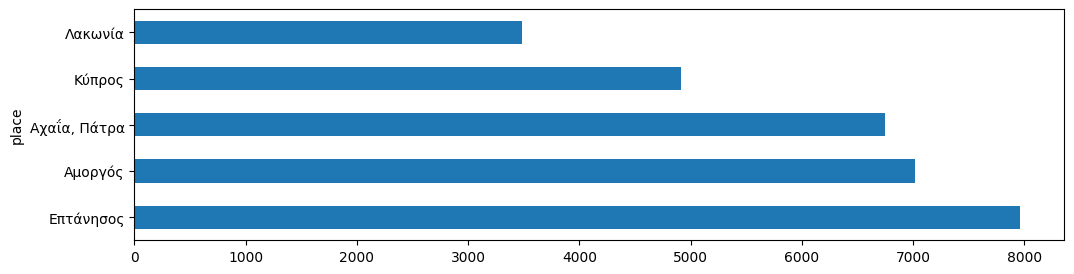

In [31]:
proverbs_sp.place.value_counts()[:5].plot.barh(figsize=(12,3));

* Visualising the places along with the number of proverbs collected there

In [32]:
freq_places = proverbs_sp.place.value_counts()[:20]
m = folium.Map(location=[39.0742, 21.8243], zoom_start=5)
for i in range(10):
    freq = freq_places.iloc[i]
    place = freq_places.index[i].split(",")[0]
    loc = geolocs[place]
    folium.CircleMarker((loc["lat"], loc["lon"]), 
                  radius=freq/500,
                  popup=f"{freq}",
                  color="#3186cc",
                  fill=True,
                  fill_color="#3186cc").add_to(m)
m.save('frequent_places.html'); m

* Next, we work with ones that own 1,000 or more proverbs, allowing sampling without class imbalance issues

In [33]:
group_level = "area"
placed = proverbs_sp.groupby(group_level)
placed_pd = pd.DataFrame({"text": placed.text.apply(list)})
placed_pd["length"] = placed_pd.text.apply(len)
print(f"Out of the {placed_pd.shape[0]} places, {placed_pd[placed_pd.length>1000].shape[0]} own 1000 proverbs or more.")

Out of the 129 places, 23 own 1000 proverbs or more.


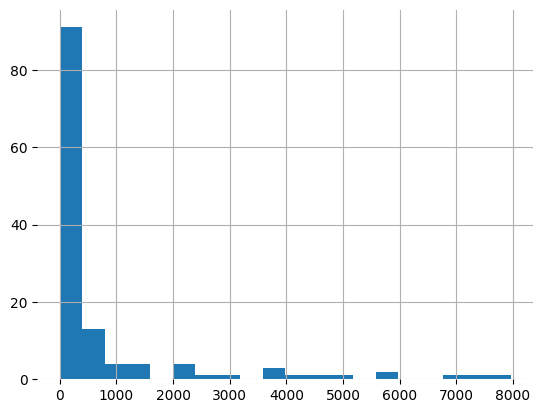

In [34]:
placed_pd.length.hist(bins=20);
sns.despine(left=True, bottom=True)

* The proverbs from places reported at least 1,000 times are more than 80,000


In [35]:
common_places = placed_pd[placed_pd.length>1000].index
# filtering texts found on these places
common_sayings = proverbs_sp[proverbs_sp[group_level].isin(common_places)]
print(f"Found {common_sayings.shape[0]} proverbs from {len(common_places)} places")

Found 80893 proverbs from 23 places


* Removing proverbs with unknown (invalid?) characters

In [36]:
stopchars = {'$', '*', '+', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'G', 'H', 'I', 'N', 'O', 'P', 'S', 'T', 'W', '[', ']', 'a','b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'y', 'z', 'ä', '\ufeff'}
common_sayings_norm = common_sayings[~common_sayings.text.apply(lambda x: len(set(x).intersection(stopchars))>0)]

* Creating a location-balanced corpus


In [37]:
balanced_corpus = pd.concat([common_sayings_norm[common_sayings_norm.area==a].sample(500) for a in common_places])
balanced_corpus.shape

(11500, 7)

## Location-based TF * IDF
* For each place, we compute character n-gram frequencies (TF).
* Terms infrequent across all places are more important (IDF). 

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [39]:
long_texts = [" \n ".join(balanced_corpus[balanced_corpus.area==a].text.values) for a in common_places]
vect = TfidfVectorizer(ngram_range=(2,5), analyzer="char", max_df=0.5, min_df=5, lowercase=True)
X = vect.fit_transform(long_texts)

In [40]:
# computing the TFIDF per place
geotfidf = pd.DataFrame(columns = common_places, index=vect.get_feature_names_out())
for i, a in enumerate(common_places):
    geotfidf[a] = np.array(X[i].sum(0))[0]

* Sorting the frequencies per place, gives characteristic n-grams; i.e., frequent locally yet infrequent globally.

In [41]:
geotfidf.sort_values(by="Κύπρος", ascending=False).head(3)

area,Ήπειρος,Αιτωλία,Αμοργός,Ανατολική Θράκη,Αρκαδία,Αχαΐα,Επτάνησος,Εύβοια,Θεσπρωτία,Θράκη,...,Κρήτη,Κύπρος,Λέσβος,Λακωνία,Μακεδονία,Μικρά Ασία,Νάξος,Πόντος,Ρόδος,Σκύρος
τζα,0.000000,0.000000,0.0,0.007020,0.0,0.000000,0.0,0.005902,0.0,0.007038,...,0.005727,0.320947,0.0,0.0,0.000000,0.006523,0.011902,0.004886,0.000000,0.018248
μ μ,0.007882,0.005630,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.201854,0.0,0.0,0.006981,0.007258,0.000000,0.032622,0.058783,0.000000
μ π,0.074108,0.081812,0.0,0.006677,0.0,0.114488,0.0,0.028067,0.0,0.006694,...,0.000000,0.179174,0.0,0.0,0.011934,0.000000,0.000000,0.032531,0.045222,0.000000


* Computing a lexicon with the terms with the highest TFIDF value per area

In [42]:
area_ngrams = {a:list(geotfidf.sort_values(by=a, ascending=False)[a].head(3).index) for a in common_places}

* Locating the important terms on the map

In [43]:
m = folium.Map(location=[39.0742, 21.8243], zoom_start=5)
for a in area_ngrams:
    ngrams = ", ".join(area_ngrams[a])
    loc = geolocs[a]
    folium.Circle([loc["lat"], loc["lon"]], 20000, fill=True).add_child(folium.Popup(ngrams)).add_to(m)
m.save('frequent_ngrams.html'); m

In [44]:
geotfidf.to_csv("geotfidf.csv")

In [45]:
pd.DataFrame(area_ngrams)

,Ήπειρος,Αιτωλία,Αμοργός,Ανατολική Θράκη,Αρκαδία,Αχαΐα,Επτάνησος,Εύβοια,Θεσπρωτία,Θράκη,...,Κρήτη,Κύπρος,Λέσβος,Λακωνία,Μακεδονία,Μικρά Ασία,Νάξος,Πόντος,Ρόδος,Σκύρος
0,μ π,ου,μεν,'νε,ν πον,! ε,ναν,τσαι,(το,πε,...,τση,τζα,τσι,ςτ,ου,τουν,'ι,'ς σ,(γ),τσαί
1,τουν,τουν,μήδ,'νε,ή α,ο!,ναν,τσαι,(το,'ς τη,...,τση,μ μ,νιρ,πιε,σι,κη,ντο,ν ατ,γ),σαί
2,ου,μι,μήδ,φθ,ή απ,ο!,ονε,τσαι,ο),πε τ,...,όντε,μ π,νιρ,πιε,τς,νιν,βγε,άτ,(γ,τσαι


# Authorship analysis
* Training one language model per area, by sampling proverbs of that area



In [46]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(balanced_corpus, test_size=0.05, random_state=2023)
train, dev = train_test_split(train, test_size=test.shape[0], random_state=2023)

In [47]:
# INFO: robustness at stake
#!git clone https://github.com/ipavlopoulos/lm
from lm.markov.models import LM
from lm.neural.models import 
models = {}
for area in train.area.unique():
    texts = train[train.area==area].text.values
    models[area] = LM(gram="CHAR").train(" \n ".join(texts))
    
def ling_dist(proverb, models=models):
    entropy = {loc:[models[loc].ppl(proverb)] for loc in models.keys()}
    likelier = min(entropy, key=entropy.get) 
    return likelier, pd.DataFrame(entropy)

loc, dists = ling_dist('κακό χωριό τα λίγα σπίτια')
dists.sort_values(by=0, ascending=True, axis=1)

SyntaxError: invalid syntax (2891407673.py, line 4)

* Evaluating on unseen proverbs

In [ ]:
from sklearn.metrics import *
predictions = test.text.apply(lambda x: ling_dist(x, models=models)[0])
print(classification_report(test.area.values, predictions, zero_division=0))

* The confusion matrix can inform us about the confusion in the predictions

In [ ]:
plt.rcParams["figure.figsize"] = (8,8)
plt.rcParams["axes.labelsize"] = 12
cm = ConfusionMatrixDisplay.from_predictions(test.area.values, predictions, xticks_rotation='vertical', colorbar=False);
cm.figure_.tight_layout()
cm.figure_.savefig('authorship_confusion.pdf', format="PDF", dpi=300)

# Text spatial classification
* Trying with a standard text classifier improves slightly the accuracy but similar findings are reported

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.neighbors import KNeighborsClassifier

Learning a location classifier on top of character n-grams

In [ ]:
# text classification flat
vect = TfidfVectorizer(ngram_range=(2,5), analyzer="char", max_df=0.5, min_df=5, lowercase=True)
locator = Pipeline([('vect', vect), ('clf', LogisticRegression())])
locator.fit(train.text.values, train.area.values)
txt_preds = locator.predict(test.text.values)
print(classification_report(test.area.values, txt_preds, zero_division=0))

In [ ]:
cm = ConfusionMatrixDisplay.from_estimator(locator, test.text.values, test.area.values, xticks_rotation='vertical', colorbar=False);
cm.figure_.tight_layout()

# Classifying multi-located proverbs

* Such a classifier can give an estimate about the origins of proverbs multiply located  

In [ ]:
duplicated_predicted_pd = duplicates[duplicates.area_num>1]
duplicated_predicted_pd.insert(4, "prediction", locator.predict(duplicated_predicted_pd.index.values))
duplicated_predicted_pd.insert(5, "confidence", probs.max(1))
probs = locator.predict_proba(duplicated_predicted_pd.index.values)
# duplicated_predicted_pd.reset_index().to_excel("sayings_duplicated_located.xlsx", index=False)
duplicated_predicted_pd.sort_values(by="confidence", ascending=False).head(20)

# Regression on the coordinates
* Instead of classifying the place, we can learn to predict the geographical coordinates.
* By using linear regression, we can measure feature importance afterwards, n-grams which distinguish spatially, from South to North, from West to East. 

In [ ]:
vect = TfidfVectorizer(ngram_range=(1,5), analyzer="char", max_df=0.5, min_df=5, lowercase=True)
linear = Pipeline([('vect', vect), ('reg', LinearRegression())])
linear.fit(train.text.values, train[["lat", "lon"]].values)
txt_preds = linear.predict(test.text.values)

* R2 is the coefficient of determination, measuring how well a statistical model predicts the model's dependent variable (the outcome).

In [ ]:
print(f'R2 (train): {linear.score(train.text, train[["lat", "lon"]].values):.3f}')
print(f'R2 (dev): {linear.score(dev.text, dev[["lat", "lon"]].values):.3f}')

In [ ]:
print(f"MAE lat/lon: {mean_absolute_error(test.lat.values, txt_preds[:, 0]):.2f} / {mean_absolute_error(test.lon.values, txt_preds[:, 1]):.2f}")

* The error shows promising behaviour.
* Another measure is accuracy, defined based on some threshold.
* For example, measuring the number of texts whose lat, lon, lat and lon, was predicted within some threshold (e.g., 0.5, 1, 1.5).  

In [ ]:
acc = pd.DataFrame({"gold_lat": test.lat.values, "gold_lon": test.lon.values, 
                    "pred_lat": txt_preds[:, 0], "pred_lon": txt_preds[:, 1]})

In [ ]:
legit = []
thresholds = [10, 5, 2, 1, 0.5, 0.2, 0.1]
for th in thresholds: 
    legit.append(acc[acc.apply(lambda row: abs(row.gold_lat-row.pred_lat)<th and abs(row.gold_lon-row.pred_lon)<th, 1)].shape[0]/acc.shape[0])
pd.DataFrame({"valid": legit}, index=thresholds).plot.bar();

In [ ]:
importance_pd = pd.DataFrame({"feature":linear["vect"].get_feature_names_out(), 
                              "lat": linear["reg"].coef_[0, :],
                              "lon": linear["reg"].coef_[1, :]})

* n-grams pushing north (i.e., higher lat)


In [ ]:
importance_pd.sort_values(by="lat", ascending=False).head(5)

* n-grams pushing south (lower lat)


In [ ]:
importance_pd.sort_values(by="lat", ascending=True).head(5)

* n-grams pushing east (higher lon)


In [ ]:
importance_pd.sort_values(by="lon", ascending=False).head(5)

* n-grams pushing west (lower lon)


In [ ]:
importance_pd.sort_values(by="lon", ascending=True).head(5)

# Proverb alteration

* We alread observed that duplicates exist, but near duplicates may also be present, due to spatial propagation.
* We investigate this hypothesis, by measuring the edit distance per proverb, using ones co-existing in many areas.

In [ ]:
highly_distr = duplicates.sort_values(by='area_num', ascending=False).head(3)
highly_distr

Measuring the edit distance between each of this and all other (non-duplicate) proverbs

In [ ]:
from Levenshtein import distance as lev
i = 0
target = highly_distr.reset_index().iloc[i].text
candidates = proverbs
candidates["lev"] = candidates.text.map(lambda x: lev(x, target))
near_duplicates = candidates[(candidates.lev<5)&((candidates.lev>0))]
near_duplicates

In [ ]:
set(near_duplicates.area.values) - highly_distr.reset_index().iloc[i].area

# Agglomerative clustering

* Besides duplicate proverbs, near-duplicates also exist, probably due to the spatial propagation of proverbs over time. 
* We employ linguistic distance to estimate the route of a proverb, assuming that shorter travels lead to fewer edits.   


```
input: proverb target, threshold e
output: the target's dendrogram
1. for proverb in proverbs:
2.   dist[proverb] = edit_distance(proverb, target)
3. sort(dist, ascending=True)
4. filtered = [p in dist if dist[p]<e] 
5. representations = TFIDF(filtered)
6. dendrogram = Ward(representations)
```

* Picking a proverb to act as our target
* Note that this can be shared across locations, or not

In [ ]:
# taken from: https://www.i-diadromi.gr/2013/09/blog-post_7104.html
target = "άλλαξε ο μανωλιός κι έβαλε τα ρούχα του αλλιώς".lower()
proverbs[(proverbs.text.str.lower().str.contains(target))]

* Fetching proverbs up to a given linguistic distance compared to our target
* Using edit distance, we consider proverbs with few edits as candidate paraphrases of our target

In [ ]:
#!pip install python-Levenshtein
from Levenshtein import distance as lev
candidates = proverbs
candidates["lev"] = candidates.text.map(lambda x: lev(x, target))

In [ ]:
close_candidates = candidates[candidates.lev < 20]
close_candidates.sample(5)

* Hierarchically clustering the candidate versions of our target proverb
* Employing single linkage, using the minimum distance between the proverbs of two clusters as a criterion for merging.
* Based on the assumption that the fewer edits reflect the chosen route.  

In [ ]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

In [ ]:
vec = TfidfVectorizer(analyzer="char", ngram_range=(3,5), lowercase=True, strip_accents="unicode")
X = vec.fit_transform(close_candidates.text.values)
Z = linkage(X.toarray(), 'single')
plt.figure(figsize=(10, 5))
dendrogram(Z,
orientation='top',
           labels=close_candidates.area.values,
           distance_sort='descending',
           show_leaf_counts=False,
           leaf_font_size=8.,
           show_contracted=True,
          ); plt.show();

* To better understand the clustering, we create a dataframe and filter based on distance

In [ ]:
clustering = fcluster(Z, t=0.7, criterion='distance')
close_candidates.insert(7, "clustering", clustering)
#close_candidates["clustering"] = clustering
grouped = close_candidates.groupby("clustering")
clusters = pd.DataFrame({"cluster":grouped.area.apply(list), "text":grouped.text.apply(list)})
clusters[clusters.cluster.apply(len)>1]

In [ ]:
# focus on clusters with more than one area
for i, row in clusters[clusters.cluster.apply(len)>1].iterrows():
    # hash to avoid duplicated areas (neighbouring proverbs)
    d = dict(list(zip(row.cluster, row.text)))
    if len(d)>1: # ignore duplicates
        # print the clustered versions  
        for place in d:
            print(f'{place} --> {d[place]}')
        print()